# Machine Learning Project - Building a Machine Learning Model To Predict How Well Weight Lifting Exercises Is Done

### Surya Prakash Karasala

## Abstract
The project uses data from the Weight Lifting Exercises (WLE) Dataset (see http://groupware.les.inf.puc-rio.br/har and also the References section below.) According to the WLE website, six participants were asked to perform one set of 10 repetitions of the Unilateral Dumbbell Biceps Curl in five different fashions, identified as classes A, B, C, D and E. Class A corresponds to a correct execution of the exercise, and the remaining five classes identify common mistakes in this weight lifting exercise. Several sensors were used to collect data about the quality of the exercise execution. The goal of this project is to obtain a prediction algorithm that takes such a set of sensor readings and correctly predicts the corresponding class (A to E).
The following analysis uses a random forest prediction algorithm to accomplish this task, after some data cleaning. The results of the analysis confirm that the model provided by this algorithm achieves a high prediction accuracy (as indicated by several prediction quality indicators).


## Project Methodology and Code for the Analysis.
### Data File Loading and Initial Data Exploration.
The project assignment includes two data files (in csv format), that can be downloaded from these links:
1.	Training data: pml-training.csv.
2.	Testing data: pml-testing.csv.
The following code assumes that these data files are located in your R working directory. The pml-training.csv file contains both sensor data and execution type data, but the pml-testing.csv file does not contain execution type data. As an additional part of the assignment, we have to use the prediction algorithm trained on the data from the pml-testing.csv file, in order to predict the execution type for the data in the pml-testing.csv file.
In this assignment there is no codebook for the data files. However, relevant information can be obtained from the sources cited in the references. In particular, we know that four types of sensors were used in the experiment, and we will see below that this is reflected in the names of many of the variables in the data set.
Let us begin by reading the pml-training.csv file into R. An initial inspection of the data file (using e.g. a text editor or a spreadsheet program) shows that:
1.	The data columns in the file are separated by commas.
2.	There are many missing values. These missing values come in two versions: the usual NA value, but also as values of the form “#DIV/0!” (this is probably the result of an attempt to divide by zero in a spreadsheet).
3.	The header line contains the names of the variables in the data set.
4.	The first column is not really a variable, it just contains the row number.
Taking all that into account, we read the csv into a data frame in R as follows

### Load the data



In [27]:
training <- read.csv("https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv")
testing <-read.csv("https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv")

### Step 1: Clean data

#### In training and testing set, remove columns which are all NA (since we cannot get any prediction value from them)

In [33]:
library(dplyr)
library(stats)
library(base)
# keep the same columns in training & testing set
testing<-testing[,colSums(is.na(testing))<nrow(testing)]
li<-c(colnames(testing)[1:59],"classe")
training<-training %>% select(li)
rm(li)

#### Find columns which contain missing values

In [34]:
colnames(training)[colSums(is.na(training))>0]

character(0)

#### Find how many NAs are in these columns

In [35]:
sum(is.na(training$magnet_dumbbell_z))
sum(is.na(training$magnet_forearm_y))
sum(is.na(training$magnet_forearm_z))

[1] 0

[1] 0

[1] 0

#### Find row index for the NA rows

In [36]:
which(is.na(training),arr.ind=TRUE)

row,col


In [37]:
dim(training)

[1] 19622    60

#### Find out data type for each column, and only select numeric columns to build the model


In [38]:
numeric<-lapply(training,is.numeric)
# add a column for classe variable
numeric$classe<-TRUE
# remove non-numeric columns
numeric$X1<-FALSE
numeric$user_name<-FALSE
numeric$raw_timestamp_part_1<-FALSE
numeric$raw_timestamp_part_2<-FALSE
numeric$cvtd_timestamp<-FALSE
numeric$num_window<-FALSE
numericCol<-unlist(numeric)
training<-training[,numericCol]
testing<-testing[,numericCol]
colnames(testing)[53]<-"classe"
rm(numeric)

### Step 2: split the training set into a sub-training (70%) and testing(30%) set

In [39]:
library(caret)
library(lattice)
library(ggplot2)
set.seed(1)
inTrain<-createDataPartition(y=training$classe,p=0.7,list=FALSE)
training_sub<-training[inTrain,]
testing_sub<-training[-inTrain,]

### Step 3: build model on Training the Predictor.
We will use the randomForest function (in the randomForest package) to fit the predictor to the training set. In the computer used for this analysis (see the Notes section below for details) the default number of trees (500) gives a reasonable tradeoff between training time and accuracy. In more powerful machines that number can be increased for (slightly) better predictions.

In [44]:
library(ggplot2)
library(dplyr)
library(randomForest)
#rfNews()

time1 = proc.time()
(randForest = randomForest(classe~., data=training, ntree = 500))


Call:
 randomForest(formula = classe ~ ., data = training, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 0.01%
Confusion matrix:
     A    B    C    D    E  class.error
A 5580    0    0    0    0 0.0000000000
B    1 3796    0    0    0 0.0002633658
C    0    0 3422    0    0 0.0000000000
D    0    0    0 3216    0 0.0000000000
E    0    0    0    0 3607 0.0000000000

In [45]:
time2 = proc.time()
(time = time2 - time1)

   user  system elapsed 
 47.112   0.612  47.729 

As the above results show, the resulting predictor has a quite low OOB (out-of-bag) error estimate. The confusion matrix for the training set indicates that the predictor is accurate on that set.

#### Applying the Model to the Testing Subsample.
After training the predictor we use it on the testing subsample we constructed before, to get an estimate of its out of sample error.

In [46]:
predictionTesting = predict(randForest, newdata = testing_sub)

The error estimate can be obtained with the confusionMatrix function of the caret package:

In [47]:
library(caret)
install.packages('e1071', dependencies=TRUE)
confusionMatrix(predictionTesting, testing_sub$classe)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1674    0    0    0    0
         B    0 1139    0    0    0
         C    0    0 1026    0    0
         D    0    0    0  964    0
         E    0    0    0    0 1082

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9994, 1)
    No Information Rate : 0.2845     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   1.0000   1.0000   1.0000   1.0000
Specificity            1.0000   1.0000   1.0000   1.0000   1.0000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Prevalence      

Both the accuracy and the Cohen’s kappa indicator of concordance indicate that the predictor seems to have a low out of sample error rate.

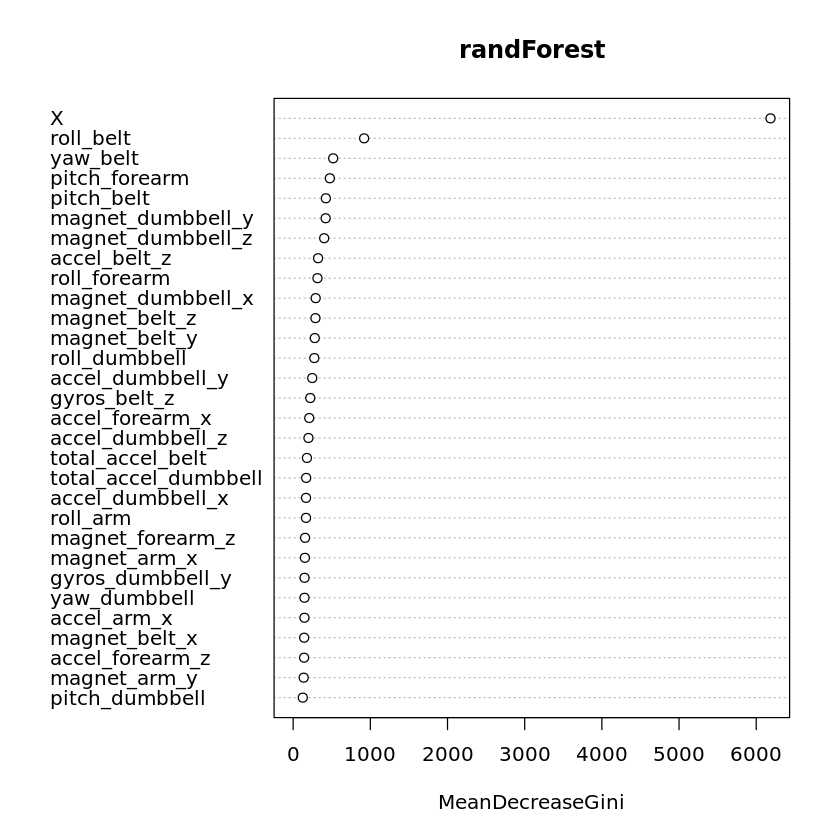

In [48]:
varImpPlot(randForest)

While random forests are not easily interpretable predictors, the variable importance analysis offers at least some insight into the model. But if we were to use PCA, even this would be obscured. Therefore, I decided to keep the predictor based in the original variables. Fine tuning of the model performance based on that importance classification could be considered, if the model is to be implemented in a production setting.

R version and System information for this analysis:

In [49]:
Sys.info()[1:2]

sysname             release 
            "Linux" "4.4.0-201-generic"

In [50]:
R.version.string

[1] "R version 3.6.1 (2019-07-05)"

As an additional prediction test, the predictor constructed here was used for the Prediction part of this Assignment, for the data in the pml-testing.csv file, and 20 out 20 cases were correctly predicted.
